In [24]:
using CSV, DataFrames, Statistics, Dates, Plots, LinearAlgebra, DecisionTree, Random

In [25]:
trainData = CSV.read("./data/train.csv", DataFrame)
testData = CSV.read("./data/test.csv", DataFrame)
first(trainData, 5)

Row,annee,type,nombre_cylindres,cylindree,transmission,boite,consommation
,Int64,String31,Int64,String3,String15,String15,String31
1,2023,voiture_moyenne,8,"4,4",integrale,automatique,"13,8358823529412"
2,2020,VUS_petit,4,2,integrale,automatique,"9,80041666666667"
3,2021,voiture_compacte,6,"3,3",propulsion,automatique,"11,7605"
4,2023,voiture_deux_places,8,5,integrale,automatique,"13,0672222222222"
5,2022,voiture_moyenne,8,"4,4",integrale,automatique,"13,8358823529412"


In [48]:
#= trainData.consommation = parse.(Float64,replace.(trainData.consommation, "," => ".")) =#
trainData.cylindree = parse.(Float64,replace.(trainData.cylindree, "," => ".")) 

testData.cylindree = parse.(Float64,replace.(testData.cylindree, "," => "."))

LoadError: MethodError: no method matching similar(::Float64, ::Type{Any})

[0mClosest candidates are:
[0m  similar([91m::ZMQ.Message[39m, ::Type{T}, [91m::Tuple{Vararg{Int64, N}} where N[39m) where T
[0m[90m   @[39m [36mZMQ[39m [90mC:\Users\Antoine\.julia\packages\ZMQ\7UMJa\src\[39m[90m[4mmessage.jl:162[24m[39m
[0m  similar([91m::SubArray[39m, ::Type, [91m::Tuple{Vararg{Int64, N}} where N[39m)
[0m[90m   @[39m [90mBase[39m [90m[4msubarray.jl:65[24m[39m
[0m  similar([91m::Vector{T}[39m, ::Type) where T
[0m[90m   @[39m [90mBase[39m [90m[4marray.jl:417[24m[39m
[0m  ...


In [49]:
possibles = unique(trainData.consommation)

25-element Vector{Float64}:
 13.8358823529412
  9.80041666666667
 11.7605
 13.0672222222222
  7.3503125
  7.58741935483871
 11.2004761904762
 14.700625
 12.3794736842105
 10.6913636363636
  9.4084
 15.6806666666667
  8.71148148148148
  8.11068965517241
 10.2265217391304
  7.84033333333333
  8.40035714285714
  9.04653846153846
 16.8007142857143
  6.91794117647059
  6.35702702702703
  4.52326923076923
  7.12757575757576
  4.90020833333333
  6.53361111111111

In [50]:
findnearest(A::Vector{Float64},t::Float64) = A[findmin(broadcast(abs,A.-t))[2]]

findnearest (generic function with 1 method)

In [93]:
trainData[!,:volume_gaz] = trainData[!,:nombre_cylindres] .* trainData[!,:cylindree]

testData[!,:volume_gaz] = testData[!,:nombre_cylindres] .* testData[!,:cylindree]

150-element Vector{Float64}:
 10.0
 10.0
 10.0
  8.0
 46.4
 40.0
 40.0
  9.6
 21.0
 52.0
 52.0
 70.80000000000001
  8.0
  ⋮
  6.4
 19.799999999999997
 40.0
  8.0
  8.0
  6.4
  8.0
  8.0
 18.0
 18.0
  4.5
  8.0

In [52]:
function train_test_split(data, test_size=0.2, shuffle=true)
    n = size(data, 1)
    test_size = floor(Int, n * test_size)
    
    if shuffle
        indices = randperm(n)
    else
        indices = 1:n
    end
    
    test_indices = indices[1:test_size]
    train_indices = indices[test_size+1:end]
    
    train_data = data[train_indices, :]
    test_data = data[test_indices, :]
    
    return train_data, test_data
end

train_test_split (generic function with 3 methods)

In [53]:
function encode(data, column)
    for c in unique(data[!, column])
        data[!, Symbol(c)] = ifelse.(data[!, column] .== c, 1, 0)
    end
    return data
end


function encode_data(data)
    encoded_data = deepcopy(data)
    encoded_data = encode(encoded_data, :type)
    encoded_data = encode(encoded_data, :transmission)
    encoded_data = encode(encoded_data, :boite)
    encoded_data = encode(encoded_data, :nombre_cylindres)

    return encoded_data
end

function removeRows(data)
    return select!(data, Not([:type, :transmission, :boite, :nombre_cylindres]))
end

function normalize_column(data, column)
    data[!, column] = (data[!, column] .- mean(data[!, column])) ./ std(data[!, column])
    return data
end

function norm_cols(data)
    normalized_data = deepcopy(data)
    normalized_data = normalize_column(normalized_data, :cylindree)
    normalized_data = normalize_column(normalized_data, :volume_gaz)
    return normalized_data
end

norm_cols (generic function with 1 method)

In [104]:
#encoded_train = trainData
encoded_train = encode_data(encoded_train)
encoded_train = removeRows(encoded_train)

#encoded_train.cylindree = encoded_train.cylindree .- minimum(encoded_train.cylindree)
#encoded_train.volume_gaz = encoded_train.volume_gaz .- minimum(encoded_train.volume_gaz)
#encoded_train.annee = encoded_train.annee .-minimum(encoded_train.annee)


train, test= train_test_split(encoded_train)


#= encoded_train =#

X_train =  Matrix(train[:, Not(:consommation)])
y_train = train.consommation
X_test = Matrix(test[:, Not(:consommation)])
y_test = test.consommation

size(X_test),size(X_train),size(y_test),size(y_train)

((79, 29), (317, 29), (79,), (317,))

In [105]:
encoded_train

Row,annee,cylindree,consommation,volume_gaz,voiture_moyenne,VUS_petit,voiture_compacte,voiture_deux_places,voiture_minicompacte,VUS_standard,monospace,voiture_sous_compacte,camionnette_petit,break_petit,voiture_grande,camionnette_standard,break_moyen,integrale,propulsion,traction,4x4,automatique,manuelle,8,4,6,3,12,10,5
,Int64,Float64,Float64,Float64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64
1,2023,4.4,13.8359,35.2,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0
2,2020,2.0,9.80042,8.0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0
3,2021,3.3,11.7605,19.8,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0
4,2023,5.0,13.0672,40.0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0
5,2022,4.4,13.8359,35.2,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0
6,2022,4.4,13.8359,35.2,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0
7,2022,1.5,7.35031,4.5,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0
8,2024,1.5,7.58742,4.5,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0
9,2020,3.8,11.2005,22.8,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0


In [83]:
    train, test= train_test_split(encoded_train)

    X_train =  Matrix(train[:, Not(:consommation)])
    y_train = train.consommation
    X_test = Matrix(test[:, Not(:consommation)])
    y_test = test.consommation


    model = RandomForestClassifier(n_subfeatures=12, n_trees=10,min_samples_leaf=1,min_purity_increase=0.0, max_depth=10, min_samples_split=6)
    DecisionTree.fit!(model, X_train, y_train)
    y_pred = DecisionTree.predict(model, X_test)
    sqrt(mean((y_pred - test.consommation).^2))


0.8969316496195567

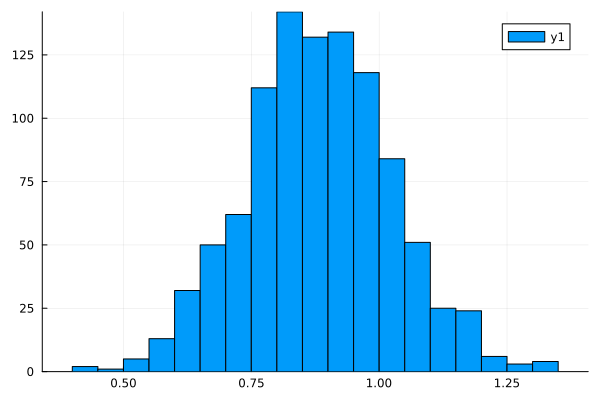

In [ ]:
n = []
for i in 1:1000
    train, test= train_test_split(encoded_train,0.1)

    X_train =  Matrix(train[:, Not(:consommation)])
    y_train = train.consommation
    X_test = Matrix(test[:, Not(:consommation)])
    y_test = test.consommation


    model = RandomForestClassifier(n_subfeatures=6, n_trees=10,min_samples_leaf=1,min_purity_increase=0.0, max_depth=10, min_samples_split=6)
    DecisionTree.fit!(model, X_train, y_train)
    y_pred = DecisionTree.predict(model, X_test)
    push!(n,sqrt(mean((y_pred - test.consommation).^2)))

end
histogram(n)

In [105]:
println(y_pred)
println(y_pred_adjusted)
println(test.consommation)

[7.973639589310716, 7.953110297911062, 10.170543036241767, 12.872409612300913, 10.0277118627438, 10.137304061234333, 13.33143643165217, 11.740898612927271, 11.357740184236619, 10.931690733884684, 8.858893079026853, 11.135459199385968, 10.638507053693628, 11.050155137413082, 12.872409612300913, 7.631137800097925, 8.102868212161418, 9.554486548846537, 10.028006762385225, 11.58474599573623, 10.273184421481496, 9.886162494262877, 7.4919492513726915, 8.15093472469588, 9.31588692246878, 13.083156300307687, 13.054463682166752, 11.453208931635112, 9.061998191212165, 13.01996285674086, 7.479806404498584, 10.379267448402802, 10.684923330019002, 10.89133213309198, 14.18057444256545, 9.531364604555966, 10.3711002600789, 10.813633778895841, 9.620434593894275, 11.318770761611878, 9.944927906469976, 10.963805949960195, 10.684923330019002, 11.271634246566421, 11.041698405917426, 11.370574294863433, 11.453754239686413, 9.723783026550409, 8.956006614236996, 13.01996285674086, 10.297757461445542, 11.3214

In [92]:
possibles

25-element Vector{Float64}:
 13.8358823529412
  9.80041666666667
 11.7605
 13.0672222222222
  7.3503125
  7.58741935483871
 11.2004761904762
 14.700625
 12.3794736842105
 10.6913636363636
  9.4084
 15.6806666666667
  8.71148148148148
  8.11068965517241
 10.2265217391304
  7.84033333333333
  8.40035714285714
  9.04653846153846
 16.8007142857143
  6.91794117647059
  6.35702702702703
  4.52326923076923
  7.12757575757576
  4.90020833333333
  6.53361111111111

In [77]:
n = 0
for i in 1:100
    train, test= train_test_split(encoded_train)

    X_train =  Matrix(train[:, Not(:consommation)])
    y_train = train.consommation
    X_test = Matrix(test[:, Not(:consommation)])
    y_test = test.consommation


    model = RandomForestRegressor(n_subfeatures=12, n_trees=600,min_samples_leaf=1,min_purity_increase=0.0, max_depth=10, min_samples_split=6)
    DecisionTree.fit!(model, X_train, y_train)
    y_pred = DecisionTree.predict(model, X_test)
    #println(y_pred)
    y_pred_adjusted = map(x -> findnearest(possibles,x),y_pred)
    n += sqrt(mean((y_pred_adjusted - test.consommation).^2))
end
println(n/100)

6.6312315702629485


In [128]:
X_test

79×23 Matrix{Float64}:
  6.0  8.0  3.8  36.4  0.0  1.0  0.0  …  0.0  1.0  0.0  0.0  0.0  1.0  0.0
  7.0  4.0  1.3   6.4  0.0  0.0  0.0     0.0  0.0  1.0  0.0  0.0  1.0  0.0
  3.0  4.0  0.8   4.4  0.0  1.0  0.0     0.0  0.0  0.0  1.0  0.0  1.0  0.0
  2.0  4.0  1.3   6.4  1.0  0.0  0.0     0.0  0.0  0.0  1.0  0.0  0.0  1.0
  9.0  4.0  1.3   6.4  0.0  0.0  0.0     0.0  1.0  0.0  0.0  0.0  1.0  0.0
  6.0  4.0  0.8   4.4  0.0  1.0  0.0  …  0.0  1.0  0.0  0.0  0.0  1.0  0.0
  7.0  4.0  0.4   2.8  0.0  0.0  1.0     0.0  0.0  0.0  1.0  0.0  0.0  1.0
  0.0  4.0  1.2   6.0  0.0  1.0  0.0     0.0  0.0  0.0  0.0  1.0  1.0  0.0
  0.0  6.0  2.1  16.2  0.0  1.0  0.0     0.0  0.0  0.0  1.0  0.0  1.0  0.0
  9.0  4.0  1.3   6.4  0.0  1.0  0.0     0.0  1.0  0.0  0.0  0.0  1.0  0.0
  9.0  8.0  3.8  36.4  0.0  0.0  0.0  …  0.0  0.0  1.0  0.0  0.0  1.0  0.0
  9.0  3.0  0.3   0.9  0.0  0.0  0.0     0.0  0.0  0.0  1.0  0.0  0.0  1.0
  8.0  4.0  0.8   4.4  0.0  0.0  0.0     0.0  0.0  0.0  1.0  0.0  0.0  1.0
  

In [117]:
minimum(trainData.cylindree)

1.2

In [ ]:

res = []
for i in 1:20
    n = 0
    for i in 1:10
        model = RandomForestRegressor(n_trees=i)
    DecisionTree.fit!(model, X_train, y_train)
    y_pred = DecisionTree.predict(model, X_test)
    n += sqrt(mean((y_pred - y_test).^2))
    end
    push!(res,n/10)
end



# display the grid
plot(1:20, res, label="RandomForestRegressor", xlabel="n_trees", ylabel="RMSE", title="RandomForestRegressor RMSE vs n_trees")

In [ ]:

res = []
for i in 1:23
    n = 0
    for j in 1:10
        model = RandomForestRegressor(n_subfeatures=i)
    DecisionTree.fit!(model, X_train, y_train)
    y_pred = DecisionTree.predict(model, X_test)
    n += sqrt(mean((y_pred - test.consommation).^2))
    end
    push!(res,n/10)
end



# display the grid
plot(1:23, res, label="RandomForestRegressor", xlabel="n_subfeatures", ylabel="RMSE", title="RandomForestRegressor RMSE vs n_trees")

In [ ]:
res = []
for i in 1:23
    n = 0
    for j in 1:10
        model = RandomForestRegressor(min_samples_leaf=i)
    DecisionTree.fit!(model, X_train, y_train)
    y_pred = DecisionTree.predict(model, X_test)
    n += sqrt(mean((y_pred - test.consommation).^2))
    end
    push!(res,n/10)
end



# display the grid
plot(1:23, res, label="RandomForestRegressor", xlabel="min_samples_leaf", ylabel="RMSE", title="RandomForestRegressor RMSE vs n_trees")

In [ ]:
res = []
for i in 1:23
    n = 0
    for j in 1:10
        model = RandomForestRegressor(min_purity_increase=i)
    DecisionTree.fit!(model, X_train, y_train)
    y_pred = DecisionTree.predict(model, X_test)
    n += sqrt(mean((y_pred - test.consommation).^2))
    end
    push!(res,n/10)
end



# display the grid
plot(1:23, res, label="RandomForestRegressor", xlabel="min_samples_leaf", ylabel="RMSE", title="RandomForestRegressor RMSE vs n_trees")

In [ ]:
res = []
for i in 2:23
    n = 0
    for j in 1:10
        model = RandomForestRegressor(min_samples_split=i)
    DecisionTree.fit!(model, X_train, y_train)
    y_pred = DecisionTree.predict(model, X_test)
    n += sqrt(mean((y_pred - test.consommation).^2))
    end
    push!(res,n/10)
end



# display the grid
plot(2:23, res, label="RandomForestRegressor", xlabel="min_samples_leaf", ylabel="RMSE", title="RandomForestRegressor RMSE vs n_trees")

In [119]:
@doc RandomForestRegressor

```
RandomForestRegressor(; n_subfeatures::Int=-1,
                      n_trees::Int=10,
                      partial_sampling::Float=0.7,
                      max_depth::Int=-1,
                      min_samples_leaf::Int=5,
                      rng=Random.GLOBAL_RNG,
                      impurity_importance::Bool=true)
```

Random forest regression. See [DecisionTree.jl's documentation](https://github.com/bensadeghi/DecisionTree.jl)

Hyperparameters:

  * `n_subfeatures`: number of features to consider at random per split (default: -1, sqrt(# features))
  * `n_trees`: number of trees to train (default: 10)
  * `partial_sampling`: fraction of samples to train each tree on (default: 0.7)
  * `max_depth`: maximum depth of the decision trees (default: no maximum)
  * `min_samples_leaf`: the minimum number of samples each leaf needs to have (default: 5)
  * `min_samples_split`: the minimum number of samples in needed for a split
  * `min_purity_increase`: minimum purity needed for a split
  * `rng`: the random number generator to use. Can be an `Int`, which will be used to seed and create a new random number generator. Multi-threaded forests must be seeded with an `Int`
  * `impurity_importance`: whether to calculate feature importances using `Mean Decrease in Impurity (MDI)`. See [`DecisionTree.impurity_importance`](@ref).

Implements `fit!`, `predict`, `get_classes`


In [488]:
@doc DecisionTreeRegressor

```
DecisionTreeRegressor(; pruning_purity_threshold=0.0,
                      max_depth::Int-1,
                      min_samples_leaf::Int=5,
                      min_samples_split::Int=2,
                      min_purity_increase::Float=0.0,
                      n_subfeatures::Int=0,
                      rng=Random.GLOBAL_RNG,
                      impurity_importance::Bool=true)
```

Decision tree regression. See [DecisionTree.jl's documentation](https://github.com/bensadeghi/DecisionTree.jl)

Hyperparameters:

  * `pruning_purity_threshold`: (post-pruning) merge leaves having `>=thresh` combined purity (default: no pruning). This accuracy-based method may not be appropriate for regression tree.
  * `max_depth`: maximum depth of the decision tree (default: no maximum)
  * `min_samples_leaf`: the minimum number of samples each leaf needs to have (default: 5)
  * `min_samples_split`: the minimum number of samples in needed for a split (default: 2)
  * `min_purity_increase`: minimum purity needed for a split (default: 0.0)
  * `n_subfeatures`: number of features to select at random (default: keep all)
  * `rng`: the random number generator to use. Can be an `Int`, which will be used to seed and create a new random number generator.
  * `impurity_importance`: whether to calculate feature importances using `Mean Decrease in Impurity (MDI)`. See [`DecisionTree.impurity_importance`](@ref)

Implements `fit!`, `predict`, `get_classes`


In [ ]:
model = DecisionTreeRegressor(n_subfeatures=12, min_samples_leaf=1,min_purity_increase=0.0, max_depth=10, min_samples_split=6,)
DecisionTree.fit!(model, X_train, y_train)
y_pred = DecisionTree.predict(model, X_test)
sqrt(mean((y_pred - test.consommation).^2))

1.1704408817014724

In [456]:
y_pred

79-element Vector{Float64}:
  1.2240951129805515
  0.17625130984704987
  1.479696235370256
 -0.2607463003952433
  1.5211869207713695
 -1.3097410769834612
 -1.376475788529015
 -1.3608160998913268
  0.6165740389681241
 -1.2787160338849795
  1.4209770672951387
  1.7941338351390625
  0.3887079431074021
  ⋮
  0.37544214897858164
 -1.5136770521451326
 -1.079500521944099
  1.174229577971678
 -1.0333093095750074
 -0.01294650848269291
 -1.2879443398905748
 -1.4793632637667964
  1.2431097360103887
 -1.304503701086083
 -0.8312720241469432
 -1.2995868865253335

In [21]:
id = 1:150

df_pred = DataFrame(id=id, consommation=res)

CSV.write("benchmark1.csv", df_pred)

"benchmark1.csv"